In [56]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad

In [57]:
def bspline_basis_functions(time, degree, knot_vector):
    knot_vector = np.array(knot_vector)
    num_basis_functions = len(knot_vector) - degree - 1
    basis_functions = np.zeros(num_basis_functions)

    for i in range(num_basis_functions):
        basis_functions[i] = bspline_basis_function(i, degree, knot_vector, time)

    return basis_functions

def bspline_basis_function(i, k, knots, t):
    if k == 0:
        if knots[i] <= t < knots[i+1]:
            return 1.0
        elif t == knots[-1] and t == knots[i+1]:
            return 1.0
        else:
            return 0.0
    else:
        denom1 = knots[i+k] - knots[i]
        if denom1 != 0:
            term1 = (t - knots[i]) / denom1 * bspline_basis_function(i, k-1, knots, t)
        else:
            term1 = 0.0

        denom2 = knots[i+k+1] - knots[i+1]
        if denom2 != 0:
            term2 = (knots[i+k+1] - t) / denom2 * bspline_basis_function(i+1, k-1, knots, t)
        else:
            term2 = 0.0

        return term1 + term2

def generate_knot_vector(num_basis_functions, degree):
    if num_basis_functions < degree + 1:
        raise ValueError("Number of basis functions must be at least degree + 1.")

    num_knots = num_basis_functions + degree + 1
    knot_vector = np.zeros(num_knots)

    knot_vector[:degree + 1] = 0.0
    knot_vector[-(degree + 1):] = 1.0

    num_internal_knots = num_knots - 2 * (degree + 1)

    if num_internal_knots > 0:
        internal_knots = np.linspace(0, 1, num_internal_knots + 2)[1:-1]  # Exclude endpoints
        knot_vector[degree + 1:-degree - 1] = internal_knots

    return knot_vector

def compute_J_matrix(degree1, knot_vector1, degree2, knot_vector2):
    num_basis_functions1 = len(knot_vector1) - degree1 - 1
    num_basis_functions2 = len(knot_vector2) - degree2 - 1
    J = np.zeros((num_basis_functions1, num_basis_functions2))

    for i in range(num_basis_functions1):
        for j in range(num_basis_functions2):
            def integrand(t):
                Ni = bspline_basis_function(i, degree1, knot_vector1, t)
                Mj = bspline_basis_function(j, degree2, knot_vector2, t)
                return Ni * Mj

            support_Ni = (knot_vector1[i], knot_vector1[i + degree1 + 1])
            support_Mj = (knot_vector2[j], knot_vector2[j + degree2 + 1])
            a = max(0.0, max(support_Ni[0], support_Mj[0]))
            b = min(1.0, min(support_Ni[1], support_Mj[1]))

            if a >= b:
                J[i, j] = 0.0
            else:
                integral_value, _ = quad(integrand, a, b)
                J[i, j] = integral_value
    return J

In [73]:
degree = 1
num_basis_functions = 3
knot_vector = generate_knot_vector(num_basis_functions, degree)
coefficients = np.random.uniform(-1, 1, size=num_basis_functions)

In [74]:
t_values = np.linspace(0, 1, 1000)
internal_knots = [0, *knot_vector[degree+1:-degree-1], 1]

s_values = [coefficients @ bspline_basis_functions(t, degree, knot_vector) for t in t_values]
breaks = [coefficients @ bspline_basis_functions(break_point, degree, knot_vector) for break_point in internal_knots]

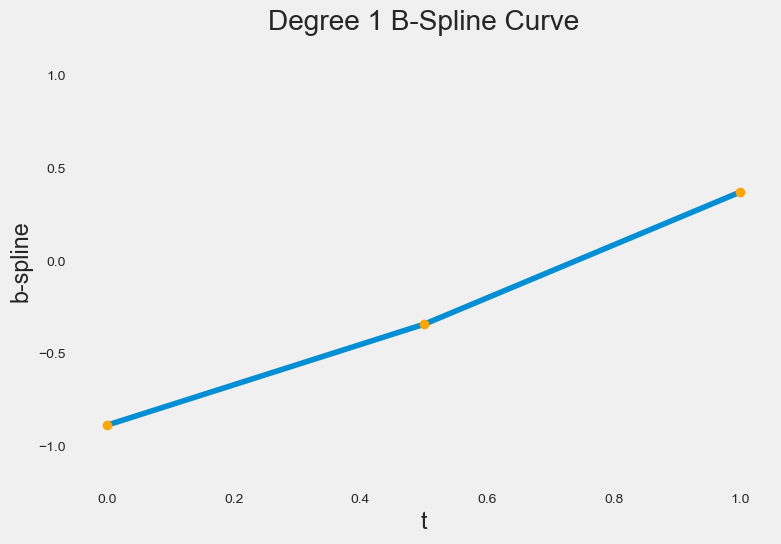

In [75]:
# Plot the resulting function
plt.style.use('fivethirtyeight')
plt.plot(t_values, s_values)
plt.plot(internal_knots, breaks, 'o', color='orange',)
plt.title(f'Degree {degree} B-Spline Curve')
plt.xlabel('t')
plt.ylabel('b-spline')
plt.ylim(-1.2, 1.2)
plt.grid(False)
plt.show()

In [76]:
degree1 = 1
degree2 = 1
num_basis_functions1 = 5
num_basis_functions2 = 3
knot_vector1 = generate_knot_vector(num_basis_functions1, degree1)
knot_vector2 = generate_knot_vector(num_basis_functions2, degree2)

In [77]:
compute_J_matrix(degree1, knot_vector1, degree2, knot_vector2)

array([[0.10416667, 0.02083333, 0.        ],
       [0.125     , 0.125     , 0.        ],
       [0.02083333, 0.20833333, 0.02083333],
       [0.        , 0.125     , 0.125     ],
       [0.        , 0.02083333, 0.10416667]])